In [1]:
!pip install livelossplot

In [2]:
import cv2
cv2.__version__

'4.5.4'

In [3]:
import os
import numpy as np
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import pandas as pd
from tqdm import tqdm
import scipy.cluster.vq as vq
import torch 



In [4]:
import random
import torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [5]:
dataroot="/kaggle/input/2022-ai-w11p1/"
csvpath=os.path.join(dataroot,"Label2Names.csv")
df_data=pd.read_csv(csvpath,header=None)
dataroottrain=os.path.join(dataroot,"train_csv_v2")
dataroottest=os.path.join(dataroot,"test_csv_v2")

In [6]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import models

In [7]:
class trainDataset(Dataset):
    def __init__(self, dataroottrain):

        self.trainlabel=[]
        self.trainpath=[]
        for classname in tqdm(os.listdir(dataroottrain)):
            if classname =="BACKGROUND_Google":
                labelindex=102
            else:
                labelindex=(df_data.index[df_data[1]==classname]+1).tolist()[0]
            for csvname in os.listdir(os.path.join(dataroottrain,classname)):
                self.trainlabel.append(labelindex-1)
                csvpath=os.path.join(dataroottrain,classname,csvname)
                self.trainpath.append(csvpath)

    def __getitem__(self, idx):
        csvpath=self.trainpath[idx]
        label=self.trainlabel[idx]
        img=np.array(pd.read_csv(csvpath)).reshape((256,256,3))
        img=img.transpose((2,0,1))
        img=torch.from_numpy(img).float()
        label=torch.tensor(label)
        return img, label
    
    def __len__(self):
        return len(self.trainpath)
    
class testDataset(Dataset):
    def __init__(self, dataroottest):

        self.testlabel=[]
        self.testpath=[]
        testsort=sorted(os.listdir(dataroottest))
        for csvname in tqdm(testsort):
            csvpath=os.path.join(dataroottest,csvname)
            self.testpath.append(csvpath)
            self.testlabel.append(csvname)
            
    def __getitem__(self, idx):
        csvpath=self.testpath[idx]
        label=self.testlabel[idx]
        img=np.array(pd.read_csv(csvpath)).reshape((256,256,3))
        img=img.transpose((2,0,1))

        img=torch.from_numpy(img).float()

        return img,label
    
    def __len__(self):
        return len(self.testpath)

In [8]:
train_data = trainDataset(dataroottrain)
test_data = testDataset(dataroottest)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=16)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=4)

100%|██████████| 1712/1712 [00:00<00:00, 411994.29it/s]
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
# models.vgg19(pretrained=True)

In [10]:
import torch.nn as nn
from torchvision import models

class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        
        self.features=pre_vgg16 = models.vgg19(pretrained=True).features
        self.avg_pool=nn.AdaptiveAvgPool2d((7, 7))
        self.classifier=nn.Linear(512*7*7,102)
        torch.nn.init.xavier_uniform(self.classifier.weight)
        self.classifier.bias.data.fill_(0.01)
        
    def forward(self, x):
        features = self.features(x)
        x = self.avg_pool(features)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [11]:
vgg19=VGG19()

for param in vgg19.features.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # This is added back by InteractiveShellApp.init_path()


In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
 
from torchvision import models
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19.classifier.parameters(), lr=1e-3)


In [13]:
# training function
from livelossplot import PlotLosses
from tqdm import tqdm 
def train(model, train_dataloader):
    liveloss = PlotLosses()
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    logs = {}
    for i, data in enumerate(tqdm(train_dataloader)):
        data, target = data[0].cuda(), data[1].cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        logs["loss"] = loss.item() 
        liveloss.update(logs)
        liveloss.draw()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
 
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

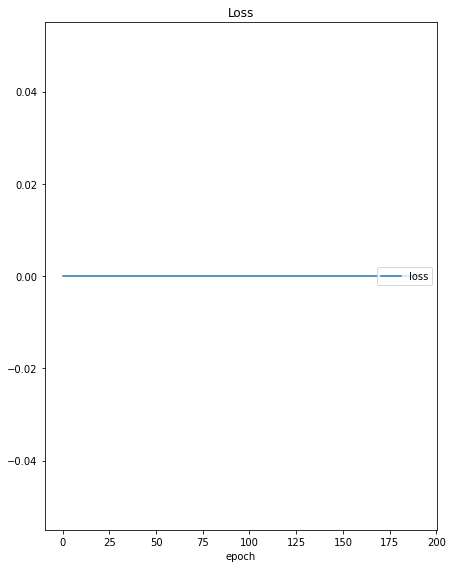

100%|██████████| 192/192 [01:35<00:00,  2.72it/s]

Loss
	loss             	 (min:    0.000, max:    0.000, cur:    0.000)


100%|██████████| 192/192 [01:36<00:00,  2.00it/s]

Train Loss: 0.0000, Train Acc: 100.00
[38.529411764705884, 82.6470588235294, 89.80392156862744, 91.83006535947712, 93.75816993464052, 93.33333333333333, 94.34640522875817, 95.13071895424837, 95.62091503267973, 97.45098039215686, 96.50326797385621, 97.05882352941177, 97.48366013071896, 97.87581699346406, 97.3529411764706, 96.63398692810458, 97.84313725490196, 98.26797385620915, 96.79738562091504, 96.5359477124183, 97.41830065359477, 97.45098039215686, 97.94117647058823, 98.0718954248366, 97.51633986928104, 98.59477124183006, 97.90849673202614, 98.85620915032679, 99.18300653594771, 99.31372549019608, 99.47712418300654, 98.39869281045752, 99.01960784313725, 99.2156862745098, 99.2156862745098, 98.98692810457516, 98.16993464052288, 97.3202614379085, 98.39869281045752, 98.36601307189542, 98.82352941176471, 98.95424836601308, 99.640522875817, 99.41176470588235, 99.640522875817, 99.70588235294117, 99.77124183006536, 99.18300653594771, 99.28104575163398, 99.18300653594771, 98.82352941176471, 98

In [14]:
train_loss , train_accuracy = [], []
start = time.time()
best_acc=0
vgg19=vgg19.cuda()
for epoch in range(100):
    train_epoch_loss, train_epoch_accuracy = train(vgg19, train_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    if epoch==0:
        best_model=vgg19
    else:
        if best_acc < train_epoch_accuracy:
            best_acc = train_epoch_accuracy
            best_model=vgg19
    print(train_accuracy)
    
end = time.time()
 
print((end-start)/60, 'minutes')

In [15]:
# training function
from tqdm import tqdm 
def test(model, test_dataloader):
    model.eval()
    preds_=[]
    for i, data in enumerate(tqdm(test_dataloader)):
        data, target = data[0].cuda(), data[1]#.cuda()
        with torch.no_grad():
            output = model(data)
        _, preds = torch.max(output.data, 1)
        if i==0:
            preds_=preds.cpu().numpy()
        else:
            preds_=np.concatenate((preds_,preds.cpu().numpy()),axis=None)
    return preds_

In [16]:
pred=test(vgg19,test_loader)
submit=pd.read_csv(os.path.join(dataroot,"submission.csv"))
submit.Category=pred+1
submit.to_csv("submit.csv",index=False)

100%|██████████| 107/107 [00:28<00:00,  3.82it/s]
